In [2]:
"""
BASED ON https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/12-Particle-Filters.ipynb
"""

import numpy as np
from numpy.random import uniform, multivariate_normal, dirichlet, random
from numpy.linalg import norm
from gatherMatrices import getMixtureEmissionMatrices
import pickle

np.set_printoptions(linewidth=100000)

with open("../data/allDF.pickle", "rb") as f:
    df = pickle.load(f)

emissionMatrix = getMixtureEmissionMatrices(df)

In [3]:
def create_uniform_particles(
        a_range, f_range, s_range,
        n_range, i_range,
        l_range, j_range,
        N
):
    particles = np.empty((N, 7))
    for i, (var, range) in enumerate(locals().items()):
        if var[-5:] != "range": break
        particles[:, i] = uniform(range[0], range[1], size=N)
    for i, row in enumerate(particles):
        particles[i, :] = row / sum(row)

    return particles

In [4]:
def predict(particles, phi, epsilon_var):
    """
    Move alpha forward one time step according to alpha_t = phi * alpha_t-1 + epsilon
    Note: this operation is in-place
    """
    for i, alpha_t_1 in enumerate(particles):
        while True:
            epsilon = multivariate_normal(
                mean=[0 for _ in range(len(alpha_t_1))],
                cov=np.eye(len(alpha_t_1)) * epsilon_var
            )
            alpha_t = np.matmul(phi, alpha_t_1.T).squeeze() + epsilon
            if np.all(alpha_t > 0):
                break

        particles[i, :] = alpha_t


In [5]:
def estimateParticleWeight(alpha: np.array, harmony: int, N=300) -> float:
    """
    Approximate the weight of a given particle associated with a given harmony
    :param alpha: the alpha value associated with the particle
    :param harmony: the observed harmony
    :param N: number of emission particles used to estimate the transition particle weights
    :return: Estimated weight of the given particle
    """
    samples = []
    for _ in range(N):
        p = dirichlet(alpha)
        h_dist = np.matmul(p, emissionMatrix).squeeze()
        h_dist = h_dist / norm(h_dist, ord=1)
        samples.append(h_dist[harmony]) #TODO: check that harmony index is same throughout
    return sum(samples) / len(samples)


def update(particles, harmony, weights):
    for i, particle in enumerate(particles):
        weights[i] *= estimateParticleWeight(particle, harmony, 300)
    weights += 1e-300
    weights /= sum(weights)

In [6]:
def estimate(particles, weights):
    mean = np.average(particles, weights=weights, axis=0)
    var = np.average((particles - mean) ** 2, weights=weights, axis=0)
    # mean = mean / sum(mean)
    return mean, var

In [7]:
def resample(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill(1.0 / len(weights))

In [8]:
def effective_N(weights):
    return 1.0 / np.sum(np.square(weights))

In [36]:
from filterpy.monte_carlo import systematic_resample
from numpy.random import randn
import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def run_filter(num_particles: int, harmonies: list[int], phi: np.array=np.eye(7), epsilon_var=0.1, plot=True):
    plt.figure()

    particles = create_uniform_particles(
        (0, 2), (0, 2), (0, 2), (0, 2),
        (0, 2), (0, 2), (0, 2),
        num_particles
    )
    weights = np.ones(num_particles) / num_particles

    estimates = []
    for i, harmony in tqdm(enumerate(harmonies), total=len(harmonies)):
        predict(particles, phi, epsilon_var)
        update(particles, harmony, weights)

        if effective_N(weights) < num_particles/2:
            indexes = systematic_resample(weights)
            resample(particles, weights, indexes)
            assert np.allclose(weights, 1/num_particles)

        mu, var = estimate(particles, weights)
        estimates.append(mu)

    estimates = np.array(estimates)
    print(estimates)
    if plot:
        plt.subplot(2, 1, 1)
        plt.stackplot(
            range(len(harmonies)),
            estimates[:, 0], estimates[:, 1], estimates[:, 2],
            estimates[:, 3], estimates[:, 4], estimates[:, 5], estimates[:, 6]
        )
        plt.subplot(2, 1, 2)
        for col in estimates.T:
            plt.plot(range(len(harmonies)), col, ls=(0, (1, 2)))
        plt.show()



  0%|          | 0/4 [00:00<?, ?it/s]

[[0.31364143 0.34507058 0.33139608 0.29424194 0.30426993 0.35423097 0.30054167]
 [0.45851123 0.48378003 0.46013706 0.37924152 0.38821725 0.44348666 0.48554759]
 [0.49760381 0.54364238 0.49392177 0.43565389 0.51371953 0.54692092 0.62551953]
 [0.57086175 0.66031315 0.53117335 0.44109107 0.55199374 0.61478577 0.65505392]]


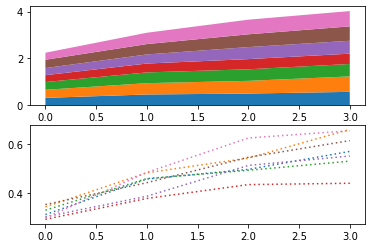

In [37]:
phi = np.array([
    [1, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 1]
])
run_filter(num_particles=100, harmonies=[2, 1, 4, 3], phi=phi, epsilon_var=0.1)

In [11]:
particles = create_uniform_particles(
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    (0, 1),
    4
)
print(particles)
predict(particles, np.eye(7), 0.01)
weights = np.array([1/len(particles) for _ in range(len(particles))])
print(particles)
update(particles, 3, weights)
print(weights)
mean, var = estimate(particles, weights)
print(mean)

[[0.11717248 0.17443584 0.09908921 0.20233182 0.10863522 0.18837073 0.10996471]
 [0.2078822  0.06165495 0.303865   0.30597952 0.01280167 0.04432445 0.06349222]
 [0.17015462 0.09615777 0.23265204 0.17527455 0.02923204 0.15835481 0.13817418]
 [0.1592674  0.12075631 0.20815287 0.01886373 0.35685798 0.08898948 0.04711223]]
[[0.30118969 0.18433459 0.15492337 0.00794328 0.07338533 0.16774686 0.02282496]
 [0.16969931 0.11225779 0.48429194 0.41524187 0.01504697 0.11767608 0.11813256]
 [0.27745909 0.28851586 0.26115981 0.19310832 0.16147207 0.25942432 0.08623627]
 [0.06598431 0.01152565 0.3234823  0.12631325 0.48346089 0.20751423 0.05579159]]
[0.31071164 0.18637491 0.27680747 0.22610597]
[0.21693303 0.16066631 0.28382863 0.16187274 0.17961612 0.19278357 0.06559458]
